This is model, where we should do binary classification - predict probability of A

   1) num_classes - number of classes
   
   2) each class has its popability of A
   
   3) prob - array of these probabilities; they are Q - coordinates for Hamiltonian MCMC
   
   4) prior (alpha, beta) are two float variables describing beta-distribution classes' popabilities.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from matplotlib.cm import rainbow
import collections

import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output

%matplotlib inline


tfd = tfp.distributions


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
def reset_tf():
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tf.reset_default_graph()
        try:
            sess.close()
        except:
            pass
        sess = tf.InteractiveSession()
        
    return sess

In [3]:
def get_example_data():
    ps_data_arr = np.array([
        [20, 10, 1, 0.499993], [20, 3, 2, 0.230211], [20, 8, 3, 0.236831], 
        [20, 7, 4, 0.246463], [20, 6, 5, 0.370862], [20, 5, 6, 0.320656], 
        [20, 10, 7, 0.519887], [20, 12, 8, 0.52845], [20, 8, 9, 0.453077], 
        [20, 8, 10, 0.431245], [20, 10, 11, 0.499243], [20, 9, 12, 0.471968], 
        [20, 2, 13, 0.152176], [20, 14, 14, 0.48496], [20, 6, 15, 0.246193]
    ])
    ps_data_pd=pd.DataFrame(data=ps_data_arr[0:, 0:],
             index=ps_data_arr[0:, 2],
             columns=["total_count", "clicks", "class_id", "true_p"],
             dtype=np.float32)
    ps_data_pd['class_id'] = ps_data_pd.class_id.astype('int32')
    
    return ps_data_pd

In [4]:
def sample_data(classes=15, alpha=1, beta=10, samples=20):
    p = np.random.beta(alpha, beta, size=classes)
    clicks = np.random.binomial(samples, p)
    
    ps_data_arr = np.array([
        [samples, clicks[i], i + 1, p[i]] for i in range(classes)
    ])
    
    ps_data_pd=pd.DataFrame(data=ps_data_arr[0:, 0:],
             index=ps_data_arr[0:, 2],
             columns=["total_count", "clicks", "class_id", "true_p"],
             dtype=np.float32)
    ps_data_pd['class_id'] = ps_data_pd.class_id.astype('int32')
    
    return ps_data_pd

In [ ]:
def sample_alpha_and_beta(ps_data_pd, sample_size, num_burnin_steps, num_steps_between_results, num_leapfrog_steps):
    
    sess = reset_tf()

    def _make_ps_prior(num_classes, alpha, beta, dtype):
        return tfd.Independent(
          tfd.Beta(
              alpha * tf.ones(num_classes),
              beta * tf.ones(num_classes) * 10),
              reinterpreted_batch_ndims=1)

    def _make_ps_log_likelihood(prob, class_id, total_count):
        prob_c = tf.gather(prob, indices=tf.to_int32(class_id - 1), axis=-1)
        total_count_c = tf.gather(total_count, indices=tf.to_int32(class_id - 1), axis=-1)
        return tfp.distributions.Binomial(total_count=tf.to_float(total_count_c), probs=prob_c)
    
    make_ps_prior = tf.make_template(name_='make_ps_prior', func_=_make_ps_prior)
    make_ps_log_likelihood = tf.make_template(name_='make_ps_log_likelihood', func_=_make_ps_log_likelihood)
    
    def joint_log_prob(prob, alpha, beta, total_count, clicks, class_id, dtype):
        num_classes = len(total_count)
        rv_prob = make_ps_prior(num_classes, alpha, beta, dtype)
        rv_clicks = make_ps_log_likelihood(prob, class_id, total_count)
        return (rv_prob.log_prob(prob) + 
             tf.reduce_sum(rv_clicks.log_prob(clicks), axis=-1))
    
    dtype = np.float32
    def unnormalized_posterior_log_prob(prob, log_alpha, log_beta):
        return joint_log_prob(
            prob=tf.sigmoid(prob),
            alpha=tf.exp(log_alpha),
            beta=tf.exp(log_beta * 10),
            total_count=dtype(ps_data_pd.total_count.values),
            clicks=dtype(ps_data_pd.clicks.values),
            class_id=np.int32(ps_data_pd.class_id.values),
            dtype=dtype)

    step_size = tf.get_variable(
        'step_size',
        initializer=0.001,
        trainable=False)
    
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(5, target_rate=0.75)
    )

    parameters_num = len(ps_data_pd)
    init_random_weights = tf.placeholder(dtype, shape=[parameters_num])
    alpha_pl = tf.placeholder(dtype, shape=())
    beta_pl = tf.placeholder(dtype, shape=())
    
    next_states, kernel_results = tfp.mcmc.sample_chain(
        num_results=sample_size,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=num_steps_between_results,
        current_state=[init_random_weights, alpha_pl, beta_pl],
        kernel=hmc)
    
    accepted_results = kernel_results.accepted_results
    
    init_op = tf.initialize_all_variables()
    
    init_op.run()
    w_ = 0.5 * np.ones([parameters_num], dtype=dtype)
    
    [
      kernel_results_,
      next_states_,
      step_size_,
    ] = sess.run([
      kernel_results,
      next_states,
      step_size
    ], feed_dict={init_random_weights: w_, alpha_pl: 0, beta_pl: 0})
    
    num_accepted = kernel_results_.is_accepted.sum()
    num_drawn = kernel_results_.is_accepted.size
    acceptance_rate = num_accepted / num_drawn
    print (num_accepted, num_drawn, acceptance_rate)
    
    return np.array([next_states_[1], next_states_[2]]).T

16 656840


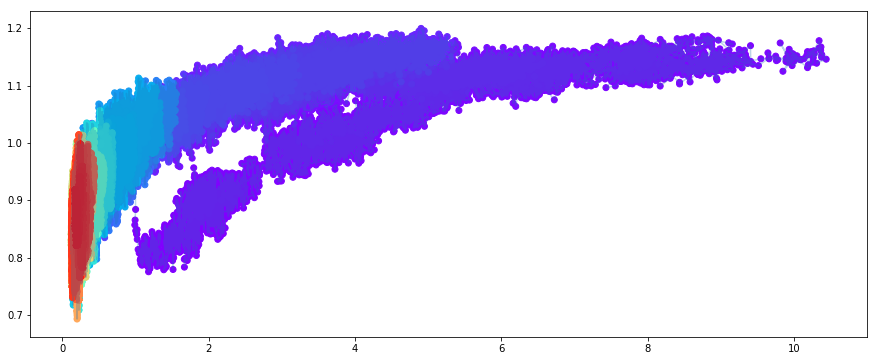

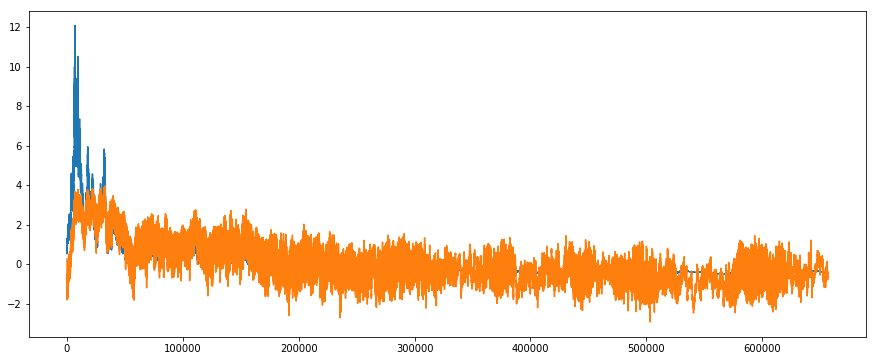

17


In [ ]:
n = 1000
chains = []
for i in range(100):
    print (i, )
    
    alpha = 1 + np.random.randint(10)
    beta = 10 + np.random.randint(100)
    samples = sample_alpha_and_beta(sample_data(classes=20, alpha=alpha, beta=beta), int(1000 * (1.5 ** i)), 0, 0, 10)
    samples = np.exp(samples)
    
    clear_output()
    
    print (i, int(1000 * (1.5 ** i)))
    
    chains.append(samples)
    
    plt.figure(figsize=(15, 6))
    plt.plot(samples[:, 0], samples[:, 1], alpha=0.3)
    plt.scatter(samples[:, 0], samples[:, 1], c=rainbow(np.linspace(0, 1, samples.shape[0])))
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot((samples[:, 0] - samples[:, 0].mean()) / samples[:, 0].std())
    plt.plot((samples[:, 1] - samples[:, 1].mean()) / samples[:, 1].std())
    plt.show()

In [7]:
"""
import pickle

with open('chain.pkl', 'wb') as output:
    pickle.dump(chains, output, pickle.HIGHEST_PROTOCOL)
"""

In [3]:
import pickle

with open('chain.pkl', 'rb') as input_:
    chains = pickle.load(input_)

In [4]:
len(chains)

22

In [5]:
for ch in chains:
    print (len(ch))

1000
1500
2250
3375
5062
7593
11390
17085
25628
38443
57665
86497
129746
194619
291929
437893
656840
985261
1477891
2216837
3325256
4987885


1477891


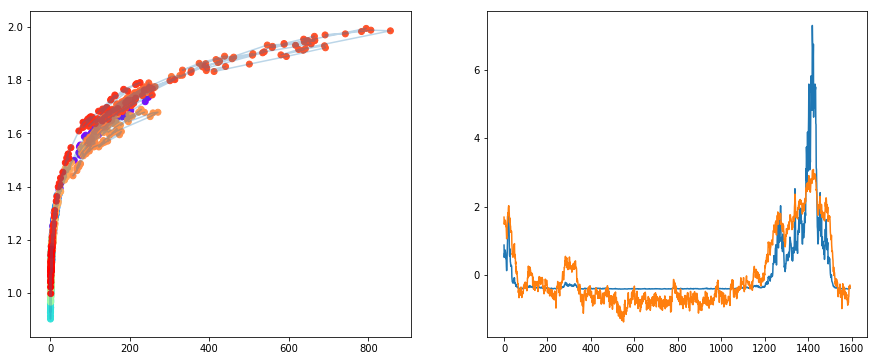

2216837


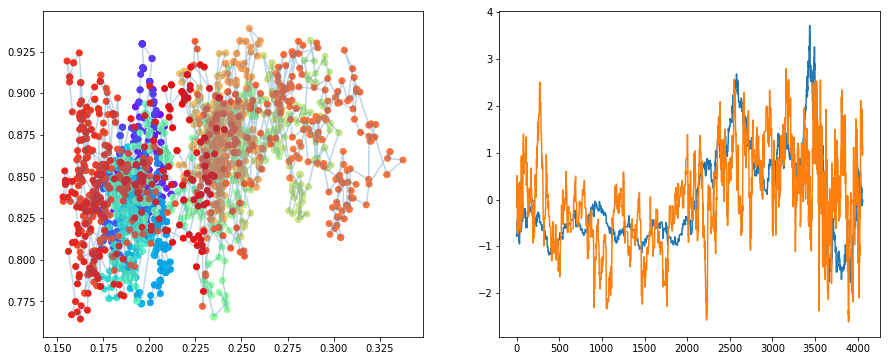

3325256


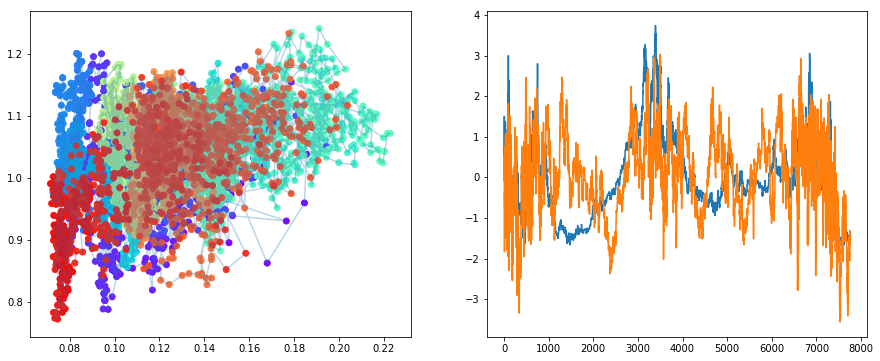

4987885


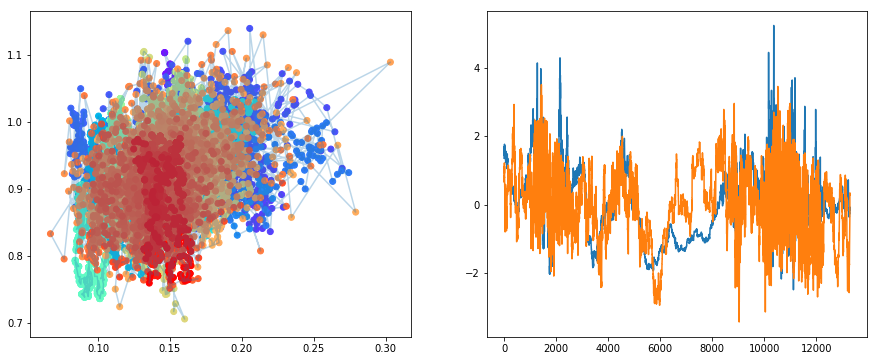

In [6]:
start = 1000000
for ch in chains:
    if len(ch) > start:
        print(len(ch))
        samples = ch[start::300]
        
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.plot(samples[:, 0], samples[:, 1], alpha=0.3)
        plt.scatter(samples[:, 0], samples[:, 1], c=rainbow(np.linspace(0, 1, samples.shape[0])))

        plt.subplot(1, 2, 2)
        plt.plot((samples[:, 0] - samples[:, 0].mean()) / samples[:, 0].std())
        plt.plot((samples[:, 1] - samples[:, 1].mean()) / samples[:, 1].std())
        plt.show()

В целом, это уже похоже на распределение плотности. Значит разумный размер burnin -- 10^6